## MuJoCo & `dm_control` Tutorial

The following is a simplified version of the official tutorial of MuJoCo and `dm_control`. You can find the official tutorial [here](https://github.com/google-deepmind/dm_control/blob/main/tutorial.ipynb). For the purpose of A3, we will use the `dm_control` package to interact with the MuJoCo environment.

In [1]:
import os
import sys
import matplotlib
import matplotlib.animation as animation

# Set the path to ffmpeg
ffmpeg_path = r'C:\Users\EdrinZ\Downloads\ffmpeg-7.1-essentials_build\ffmpeg-7.1-essentials_build\bin\ffmpeg.exe'

# Verify the path exists
if not os.path.exists(ffmpeg_path):
    raise FileNotFoundError(f"FFmpeg executable not found at {ffmpeg_path}")

# Set the ffmpeg path in matplotlib
matplotlib.rcParams['animation.ffmpeg_path'] = ffmpeg_path

# Create a proper patched_is_available function
def patched_is_available():
    # Check if the file actually exists first
    if not os.path.exists(matplotlib.rcParams['animation.ffmpeg_path']):
        print(f"Warning: FFmpeg not found at {matplotlib.rcParams['animation.ffmpeg_path']}")
        return False
    return True

# Apply the patch properly
animation.FFMpegWriter.isAvailable = patched_is_available

# Manually register the FFmpeg writer if needed
if 'ffmpeg' not in animation.writers.list():
    print("Manually registering FFmpeg writer...")
    try:
        # Try to register FFmpeg with explicit path verification
        animation.writers.register('ffmpeg', animation.FFMpegWriter)
        print("Registration successful")
    except Exception as e:
        print(f"Error registering FFmpeg: {e}")

# Make sure it's set as the default writer
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

In [2]:
# The basic mujoco wrapper.
from dm_control import mujoco
from dm_control import suite

#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


## Free bodies: the self-inverting "tippe-top"

A free body is a body with a `free` joint, with 6 movement DOFs: 3 translations and 3 rotations. We could give our `box_and_sphere` body a free joint and watch it fall, but let's look at something more interesting. A "tippe top" is a spinning toy which flips itself on its head ([Wikipedia](https://en.wikipedia.org/wiki/Tippe_top)). We model it as follows:

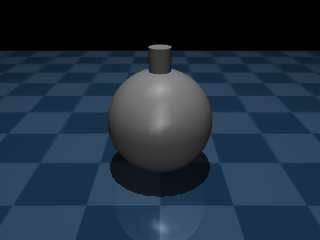

In [3]:
# @title The "tippe-top" model{vertical-output: true}

tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>
  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015" 
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>
  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(tippe_top)
PIL.Image.fromarray(physics.render(camera_id="closeup"))

Note several new features of this model definition:
0. The free joint is added with the `<freejoint/>` clause, which is similar to `<joint type="free"/>`, but prohibits unphysical attributes like friction or stiffness.
1. We use the `<option/>` clause to set the integrator to the more accurate Runge Kutta 4th order.
2. We define the floor's grid material inside the `<asset/>` clause and reference it in the floor geom. 
3. We use an invisible and non-colliding box geom called `ballast` to move the top's center-of-mass lower. Having a low center of mass is  (counter-intuitively) required for the flipping behaviour to occur.
4. We save our initial spinning state as a keyframe. It has a high rotational velocity around the z-axis, but is not perfectly oriented with the world.
5. We define a `<camera>` in our model, and then render from it using the `camera_id` argument to `render()`.
Let us examine the state:

In [4]:
print("positions", physics.data.qpos)
print("velocities", physics.data.qvel)

positions [0.   0.   0.02 1.   0.   0.   0.  ]
velocities [0. 0. 0. 0. 0. 0.]


The velocities are easy to interpret, 6 zeros, one for each DOF. What about the length-7 positions? We can see the initial 2cm height of the body; the subsequent four numbers are the 3D orientation, defined by a *unit quaternion*. These normalized four-vectors, which preserve the topology of the orientation group, are the reason that `data.qpos` can be bigger than `data.qvel`: 3D orientations are represented with **4** numbers while angular velocities are **3** numbers.

In [5]:
# @title Video of the tippe-top {vertical-output: true}

duration = 7  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
physics.reset(0)  # Reset to keyframe 0 (load a saved state).
while physics.data.time < duration:
    physics.step()
    if len(frames) < (physics.data.time) * framerate:
        pixels = physics.render(camera_id="closeup")
        frames.append(pixels)

display_video(frames, framerate)

C:\Users\EdrinZ\AppData\Local\Temp\ipykernel_29016\3258226743.py:43: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)  # Switch back to the original backend.


### Measuring values from `physics.data`
The `physics.data` structure contains all of the dynamic variables and intermediate results produced by the simulation. These are expected to change on each timestep. 

Below we simulate for 2000 timesteps and plot the state and height of the sphere as a function of time.

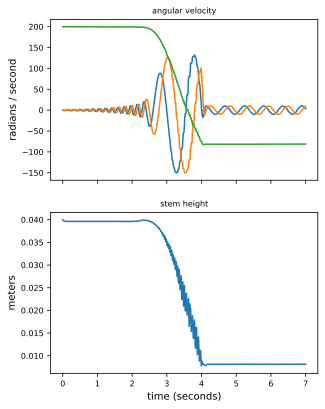

In [6]:
# @title Measuring values {vertical-output: true}
%matplotlib inline

timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
physics.reset(0)
while physics.data.time < duration:
    physics.step()
    timevals.append(physics.data.time)
    angular_velocity.append(physics.data.qvel[3:6].copy())
    stem_height.append(physics.named.data.geom_xpos["stem", "z"])

dpi = 100
width = 480
height = 640
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title("angular velocity")
ax[0].set_ylabel("radians / second")

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel("time (seconds)")
ax[1].set_ylabel("meters")
_ = ax[1].set_title("stem height")

plt.show()

# The *Control Suite*

The **Control Suite** is a set of stable, well-tested tasks designed to serve as a benchmark for continuous control learning agents. Tasks are written using the basic MuJoCo wrapper interface. Standardised action, observation and reward structures make suite-wide benchmarking simple and learning curves easy to interpret. Control Suite domains are not meant to be modified, in order to facilitate benchmarking. For full details regarding benchmarking, please refer to our original [publication](https://arxiv.org/abs/1801.00690).

A video of solved benchmark tasks is [available here](https://www.youtube.com/watch?v=rAai4QzcYbs&feature=youtu.be).

The suite come with convenient module level tuples for iterating over tasks:

In [7]:
# @title Iterating over tasks{vertical-output: true}

max_len = max(len(d) for d, _ in suite.BENCHMARKING)
for domain, task in suite.BENCHMARKING:
    print(f"{domain:<{max_len}}  {task}")

acrobot      swingup
acrobot      swingup_sparse
ball_in_cup  catch
cartpole     balance
cartpole     balance_sparse
cartpole     swingup
cartpole     swingup_sparse
cheetah      run
finger       spin
finger       turn_easy
finger       turn_hard
fish         upright
fish         swim
hopper       stand
hopper       hop
humanoid     stand
humanoid     walk
humanoid     run
manipulator  bring_ball
pendulum     swingup
point_mass   easy
reacher      easy
reacher      hard
swimmer      swimmer6
swimmer      swimmer15
walker       stand
walker       walk
walker       run


## Cartpole Balance & Swingup Tasks

In the following section, we will look at the Cartpole Balance and Swingup tasks. The Cartpole Balance task is a classic control problem where the goal is to balance a pole on a cart. The Cartpole Swingup task is a more challenging version of the Cartpole Balance task where the goal is to swing the pole up and balance it on the cart. This will be broken into two parts.

1. **Part 1:** Implement TD-Learning for both Cartpole Balance Task and Cartpole Swingup Task.
   - Define the TD-Learning algorithm function.
   - Initialize necessary parameters such as learning rate and discount factor.
   - Implement the training loop to update values using the TD-Learning algorithm.

2. **Part 2:** Explore different quantization hyperparameters to optimize the performance of the TD-Learning algorithm.
    - Implement the training loop to update values using the TD-Learning algorithm.
    - Explore different quantization hyperparameters to optimize the performance of the TD-Learning algorithm.

3. **Part 3:** Leaderboard Submission
    - Submit your best `q_table` alongside with your hyperparameter of the quantization to gradescope, we will evaluate your submission based on the performance of the `q_table` and rank your performance. The top 10 % of the submission will receive 1pts extra credit on this assignment.
    

C:\Users\EdrinZ\AppData\Local\Temp\ipykernel_29016\3258226743.py:43: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)  # Switch back to the original backend.


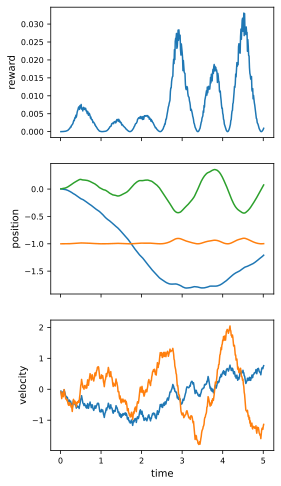

In [8]:
# @title Loading and simulating a `suite` task{vertical-output: true}

# Load the environment
random_state = np.random.RandomState(42)
env = suite.load("cartpole", "swingup", task_kwargs={"random": random_state})

# Simulate episode with random actions
duration = 5  # Seconds
frames = []
ticks = []
rewards = []
observations = []

spec = env.action_spec()
time_step = env.reset()

while env.physics.data.time < duration:
    action = random_state.uniform(spec.minimum, spec.maximum, spec.shape)
    time_step = env.step(action)
    camera0 = env.physics.render(camera_id=0, height=400, width=400)
    camera1 = env.physics.render(camera_id=1, height=400, width=400)
    frames.append(np.hstack((camera0, camera1)))
    rewards.append(time_step.reward)
    observations.append(copy.deepcopy(time_step.observation))
    ticks.append(env.physics.data.time)

html_video = display_video(frames, framerate=1.0 / env.control_timestep())

# Show video and plot reward and observations
num_sensors = len(time_step.observation)

_, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
ax[0].plot(ticks, rewards)
ax[0].set_ylabel("reward")
ax[-1].set_xlabel("time")

for i, key in enumerate(time_step.observation):
    data = np.asarray([observations[j][key] for j in range(len(observations))])
    ax[i + 1].plot(ticks, data, label=key)
    ax[i + 1].set_ylabel(key)

html_video